#### Build

In [1]:
# Upload the Github Zipfile
# Unzip the Github Zipfile
# Create python 3.8             conda create --name cse297 python=3.8.10
# Activate the environment      source activate cse297
# Within env install ipyk       pip install ipykernel
# Register kernel w/ jupy       python -m ipykernel install --user --name=capstone
# Change to package dir         cd CybORG-Competitive/CybORG/
# Install packages within env   pip install -e .
# Select 'capstone' kernel
# Confirm python version is 3.8.10
import sys
print(sys.version)

3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]


#### Import

In [2]:
from environments import build_blue_agent, build_red_agent, sample, get_timesteps, get_algorithm_select
from environments import build_cardiff_agent, sample_against_cardiff
from environments import build_mindrake_agent

import ray
import os, sys, shutil, time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
logger = logging.getLogger(__name__)

2024-05-03 17:07:23,837	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.agents.ppo.ppo::DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.ppo.ppo::PPOConfig(...)` instead. This will raise an error in the future!


#### Verify GPU

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Testing Area ###

In [ ]:
blue = build_mindrake_agent()

### Testing Area ###

#### Train Competitive Red Agent

In [4]:
# Retrieve the timestep and the algorithm selected for training
selected_timestep = get_timesteps()
selected_algorithm = get_algorithm_select()

# Select which generation we want to start training from
# If we want to train from scratch set to 1 (default value is 1)
# If we want to train from the latest generation, set to latest generation in the competitive policy pool
start_from_generation = 1

# Load rewards if training from a checkpointed generation
blue_scores = []
red_scores = []

# Total number of generations create for red agent
generations = 10

# Error checking: Update either the 'starting_from_generation' or 'total_generations' parameter
if(start_from_generation > generations):
    raise ValueError("Starting generation and Total Generation incompatible")

# Number of batches without improvement before ending training
tolerance = 3

# Create Initial Policies
ray.init(ignore_reinit_error=True, log_to_driver=False)
blue = build_blue_agent(fresh=True, opponent=True)
print("Pass 1")
red = build_red_agent(fresh=True)
print("Pass 2")

# Convert float string into a float
# Useful if loading rewards from certain generation
blue_scores = [float(item) for item in blue_scores]
red_scores = [float(item) for item in red_scores]

print()
print("+--------------------------------+")
print("| Red Competitive Training Start |")
print("+--------------------------------+")
print()

for g in range(start_from_generation, generations+1):

    # Time how long each generation takes
    g_time = time.time()

    if (g < 10):
        dashes = 14
    elif (g < 100):
        dashes = 15
    else:
        dashes = 16
    print('+'+'-'*dashes+'+')            
    print(f"| Generation {g} |")
    print('+'+'-'*dashes+'+')
    print()

    red.restore(f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/competitive_red_0/checkpoint_000000")

    b = 0
    red_max = 0
    tol = tolerance
    b_time = time.time()
    while True:
        b += 1
        start = time.time()
        result = red.train()
        
        # print(result)
        # print(result["info"])
        # print(result["info"]["learner"])
        
        end = time.time()
        elapsed_time = end-start
        # Algorithm specific score retrieval
        red_score = None
        if(selected_algorithm == "ppo" or selected_algorithm == "dqn"):
            red_score = result["sampler_results"]["episode_reward_mean"]
        else:
            red_score = result["episode_reward_mean"]
        entropy = vf_loss = 0
        if(selected_algorithm != "dqn"):
            entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
            vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Red Score: {red_score:0.2f}    Entropy: {entropy:0.2f}    VF Loss: {vf_loss:0.2f}", end="    ")
        print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
        if b > 1:
            if (red_score > red_max):
                red_max = red_score
                tol = tolerance
                checkpoint_path = red.save(checkpoint_dir=f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/competitive_red_{g}")
                path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/competitive_red_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
             # when agent is no longer improving, break and save the new best-response agent
            else:
                red_scores.append(red_max)
                red.restore(checkpoint_path)
                print('Batch time:', time.strftime("%H:%M:%S", time.gmtime(time.time()-b_time)))
                print(checkpoint_path)
                break

    pool_size = g
    pool_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    blue.restore(f"./policies/{selected_algorithm}/{selected_timestep}/blue_opponent_pool/opponent_blue_0/checkpoint_000000")

    b = 0 # b tracks the batches of training completed
    blue_min = float('inf')
    tol = tolerance
    b_time = time.time()
    while True:
        b += 1
        start = time.time()
        result = blue.train()

        # print(result)
        # print(result["info"])
        # print(result["info"]["learner"])
        
        end = time.time()
        elapsed_time = end-start
        
        # Score retrieval based on algorithm
        blue_score = None
        if(selected_algorithm == "ppo" or selected_algorithm == "dqn"):
            blue_score = -result["sampler_results"]["episode_reward_mean"]
        else:
            blue_score = -result["episode_reward_mean"]
        entropy = vf_loss = 0
        if(selected_algorithm != "dqn"):
            entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
            vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Blue Score: {blue_score:0.2f}    Entropy: {entropy:0.2f}    VF Loss: {vf_loss:0.2f}", end="    ")
        print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
        if b > 1:
            if (blue_score < blue_min):
                blue_min = blue_score
                tol = tolerance
                checkpoint_path = blue.save(checkpoint_dir=f"./policies/{selected_algorithm}/{selected_timestep}/blue_opponent_pool/opponent_blue_{g}")
                path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/blue_opponent_pool/opponent_blue_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
            # when agent is no longer improving, break and save the new competitive agent
            else:
                blue_scores.append(blue_min)
                blue.restore(checkpoint_path)
                print('Batch time:', time.strftime("%H:%M:%S", time.gmtime(time.time()-b_time)))
                print(checkpoint_path)
                break

    pool_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/blue_opponent_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    print(f'Blue Scores so far {["%.2f" % i for i in blue_scores]}')
    print(f'Red Scores so far {["%.2f" % i for i in red_scores]}')
    print("Total time: ",time.strftime("%H:%M:%S", time.gmtime(time.time()-g_time)))
    print()
    
    # print(f'-------- Sample Game for Generation {g} --------')
    # sample(red, blue, verbose=True, show_policy=True)
    # print()

selecting blue ppo config
./policies/ppo/30/blue_opponent_pool/opponent_blue_0\checkpoint_000000
Pass 1
selecting red ppo config
./policies/ppo/30/red_competitive_pool/competitive_red_0\checkpoint_000000
Pass 2

+--------------------------------+
| Red Competitive Training Start |
+--------------------------------+

+--------------+
| Generation 1 |
+--------------+

Batch 1 -- Red Score: nan    Entropy: 3.62    VF Loss: 1.22    Execution time: 00:00:02
Batch 2 -- Red Score: 3.93    Entropy: 3.62    VF Loss: 1.19    Execution time: 00:00:01
Batch 3 -- Red Score: 3.21    Entropy: 3.61    VF Loss: 0.67    Execution time: 00:00:01
Batch 4 -- Red Score: 3.06    Entropy: 3.60    VF Loss: 0.70    Execution time: 00:00:01
Batch 5 -- Red Score: 3.15    Entropy: 3.58    VF Loss: 0.16    Execution time: 00:00:01
Batch time: 00:00:08
./policies/ppo/30/red_competitive_pool/competitive_red_1\checkpoint_000002

Batch 1 -- Blue Score: nan    Entropy: 4.79    VF Loss: 1.96    Execution time: 00:00:02


#### Evaluate Red MinMax Performance

In [5]:
# Set the sample games (default is 50)
sample_games = 1

r_min = [float('inf')]*(generations+1) # red agent minimum scores
r_min_op = [0]*(generations+1) # id of blue opponent that got max score
r_best_score = 0
r_best_id = 0

# evaluate existing pool of agents
print('Evaluating Agents...')
g_start = time.time()

# iteration through red agents
for r in range(generations,0,-1):

    # If the generation exists
    if(os.path.exists(f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/competitive_red_{r}/checkpoint_path")):
        start = time.time()
        path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/competitive_red_{r}/checkpoint_path", "r")
        red_restore_path = path_file.read()
        path_file.close()
        red.restore(red_restore_path)
    
        # iterate through blue opponents
        for b in range(generations,0,-1):

            # If the generation exists
            if(os.path.exists(f"./policies/{selected_algorithm}/{selected_timestep}/blue_opponent_pool/opponent_blue_{b}/checkpoint_path")):
                path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/blue_opponent_pool/opponent_blue_{b}/checkpoint_path", "r")
                blue_restore_path = path_file.read()
                path_file.close()
                blue.restore(blue_restore_path)
                score = sample(red, blue, games=sample_games)
                if score < r_min[r]:
                    r_min[r] = score
                    r_min_op[r] = b
                    
        print(f'Red Agent {r} expects a minimum of {r_min[r]:0.2f} points, against Blue Opponent {r_min_op[r]}.', end="\t")
        print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(time.time()-start)))
        if r_min[r] > r_best_score:
            r_best_score = r_min[r]
            r_best_id = r
print()
print(f'Top performing Red Agent is generation {r_best_id}')
print("Total Execution Time: ", time.strftime("%H:%M:%S", time.gmtime(time.time()-g_start)))

path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/competitive_red_{r_best_id}/checkpoint_path", "r")
red_competitive_path = path_file.read()
path_file.close()
path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/competitive_red_policy", "w")
path_file.write(red_competitive_path)
path_file.close()

ray.shutdown()

Evaluating Agents...
Red Agent 10 expects a minimum of 1.00 points, against Blue Opponent 10.	Execution time: 00:00:08
Red Agent 9 expects a minimum of 1.00 points, against Blue Opponent 8.	Execution time: 00:00:08
Red Agent 8 expects a minimum of 0.00 points, against Blue Opponent 6.	Execution time: 00:00:08
Red Agent 7 expects a minimum of 0.00 points, against Blue Opponent 3.	Execution time: 00:00:07
Red Agent 6 expects a minimum of 1.00 points, against Blue Opponent 4.	Execution time: 00:00:08
Red Agent 5 expects a minimum of 1.00 points, against Blue Opponent 10.	Execution time: 00:00:08
Red Agent 4 expects a minimum of 0.00 points, against Blue Opponent 9.	Execution time: 00:00:08
Red Agent 3 expects a minimum of 0.00 points, against Blue Opponent 9.	Execution time: 00:00:08
Red Agent 2 expects a minimum of 1.00 points, against Blue Opponent 9.	Execution time: 00:00:08
Red Agent 1 expects a minimum of 1.00 points, against Blue Opponent 6.	Execution time: 00:00:08

Top performing 

#### Observe Exploitability of each Red Policy

In [6]:
r_exp = [] # exploitability of each Red Policy
for r in r_min[1:]:
    r_exp.append(r_best_score-r)
print(r_exp)

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]


#### Plot Red Training Scores

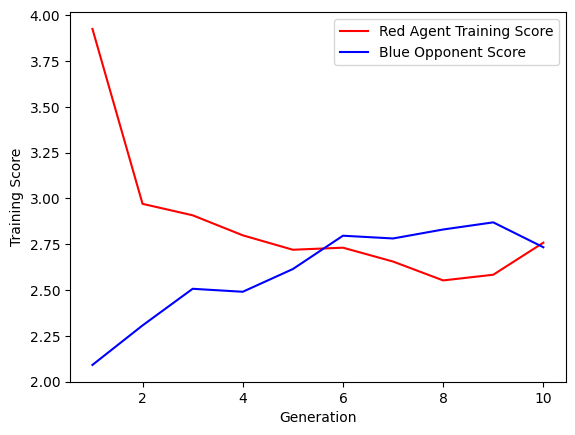

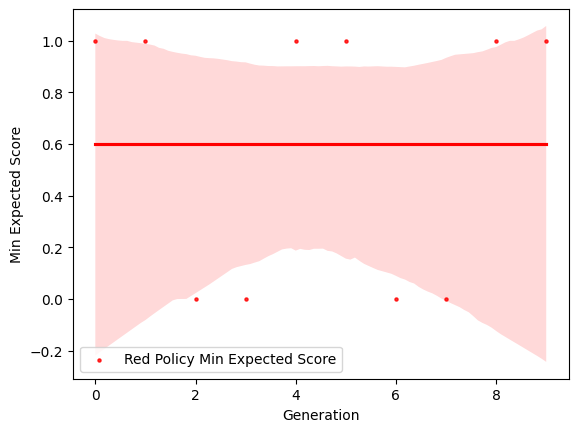

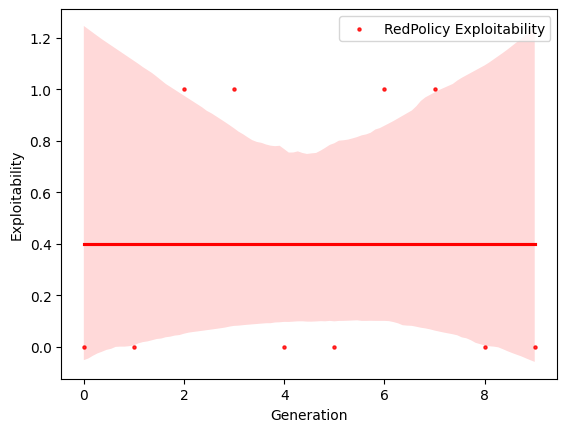

In [7]:
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot, "Training Score":red_scores, "Blue Scores":blue_scores})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Agent Training Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Opponent Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Min Expected Score":r_min[1:]})
plt.figure()
sns.regplot(x = "Generation", y = "Min Expected Score", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Min Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Exploitability":r_exp})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='red', scatter_kws={'s':5}, label="RedPolicy Exploitability")
plt.legend()
plt.show()

#### Plot Red Training Scores (First 5 points dropped)

In [ ]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Training Score":red_scores[5:], "Blue Scores":blue_scores[5:]})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Agent Training Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Opponent Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Min Expected Score":r_min[6:]})
plt.figure()
sns.regplot(x = "Generation", y = "Min Expected Score", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Min Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Exploitability":r_exp[5:]})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Exploitability")
plt.legend()
plt.show()

#### Competitive Red Agent Performance against Cardiff Blue Agent

In [ ]:
# Set the sample games (default is 50)
sample_games = 1
selected_timestep = get_timesteps()
selected_algorithm = get_algorithm_select()

# Load cardiff blue agent and optimal competitive red agent
blue_cardiff = build_cardiff_agent()
red = build_red_agent(fresh=False)
red_optimal_filepath = None
with open(f"./policies/{selected_algorithm}/{selected_timestep}/competitive_red_policy", "r") as red_file:
    red_optimal_filepath = red_file.read()
red.restore(red_optimal_filepath)

# Sample a game
# Note(1): Set sample_games=1   and verbose=1  to view the interaction between red and blue agents
# Note(2): Use sample_games>=50 and verbose=50 to get an average performance of the competitive red agent!
sample_against_cardiff(red,blue_cardiff,games=sample_games,verbose=True)

#### Train Dedicated Red Agent against Cardiff Blue Agent

In [ ]:
# Retrieve the timestep and the algorithm selected for training
selected_timestep = get_timesteps()
selected_algorithm = get_algorithm_select()

# Create red agent
# WARNING: This will -OVERWRITE- current dedicated red agent folder!
red = build_red_agent(fresh=True,dedicated=True,vs_cardiff=True)
path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/red_dedicated_pool/dedicated_red_0/checkpoint_path", "r")
red_restore_path = path_file.read()
path_file.close()
red.restore(red_restore_path)

# Save red scores
red_scores = []

# Total number of generations to train red agent
# Default is 5
generations = 2

# Number of batches without improvement before ending training
tolerance = 3

# Dedicated training
for g in range(1,generations):

     # Time how long each generation takes
    g_time = time.time()

    # Reset the red agent policy
    path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/red_dedicated_pool/dedicated_red_0/checkpoint_path", "r")
    red_restore_path = path_file.read()
    path_file.close()
    red.restore(red_restore_path)

    # Star training!
    print()
    print("+--------------------+")
    print(f"| Red Policy {g} Start |")
    print("+--------------------+")
    print()

    b = 0
    red_max = 0
    tol = tolerance
    b_time = time.time()
    while True:
        b += 1
        start = time.time()
        result = red.train()
        end = time.time()
        elapsed_time = end-start
        
        # Algorithm specific score retrieval
        red_score = None
        if(selected_algorithm == "ppo" or selected_algorithm == "dqn"):
            red_score = result["sampler_results"]["episode_reward_mean"]
        else:
            red_score = result["episode_reward_mean"]
        entropy = vf_loss = 0
        if(selected_algorithm != "dqn"):
            entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
            vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Red Score: {red_score:0.2f}    Entropy: {entropy:0.2f}    VF Loss: {vf_loss:0.2f}", end="    ")
        print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
        
        if b > 1:
            if (red_score > red_max):
                red_max = red_score
                tol = tolerance
                checkpoint_path = red.save(checkpoint_dir=f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/competitive_red_{g}")
                path_file = open(f"./policies/{selected_algorithm}/{selected_timestep}/red_competitive_pool/competitive_red_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
             # when agent is no longer improving, break and save the new best-response agent
            else:
                red_scores.append(red_max)
                red.restore(checkpoint_path)
                print('Batch time:', time.strftime("%H:%M:%S", time.gmtime(time.time()-b_time)))
                print(checkpoint_path)
                break
    print("Total time: ",time.strftime("%H:%M:%S", time.gmtime(time.time()-g_time)))